In [1]:
# Image Classification
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


CIFAR-10 Dataset: 171MB [08:44, 325kB/s]                                       


In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # total_features*RGB*H*W
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1) #(len, 32, 32, 3)
    labels = batch['labels']
    
#     print(batch['data'])
#     print("-"*80)
#     print(batch['data'].reshape((len(batch['data']), 3, 32, 32)))
#     print("-"*80)
#     print(features)
#     print("-"*80)
#     print(labels)

    return features, labels

In [4]:


def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)

In [5]:


def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1) #10%

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the test data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all test data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_testing.p')

In [7]:

def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


In [8]:
def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 5
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 100:
Image - Min Value: 5 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


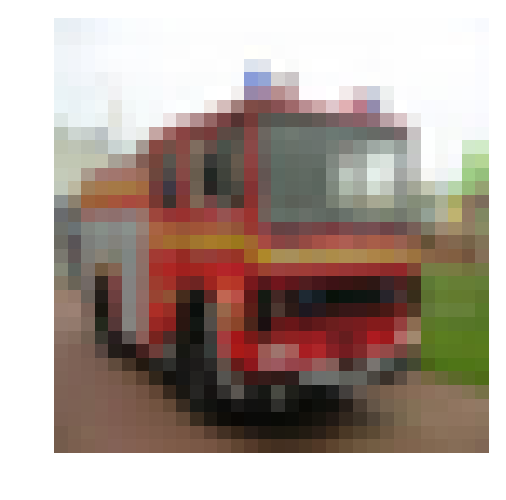

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 5 #1-5
sample_id = 100 #1-10,000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [10]:
# Min-Max normalizer
# z-normalizer (not using now)

import numpy as np
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x = np.array(x)
    x_max = np.max(x)
    x_min = np.min(x)
    output = (x - x_min)/(x_max - x_min)
    return output


In [11]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(range(10))


def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    #print(lb.transform(x))
    return lb.transform(x) #0-9


In [12]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [13]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [14]:
valid_features[0], valid_labels[0]

(array([[[ 0.54901961,  0.49019608,  0.45098039],
         [ 0.57254902,  0.50980392,  0.47843137],
         [ 0.56078431,  0.49803922,  0.47843137],
         ..., 
         [ 0.66666667,  0.56862745,  0.51372549],
         [ 0.69019608,  0.58823529,  0.5254902 ],
         [ 0.66666667,  0.57647059,  0.52156863]],
 
        [[ 0.4745098 ,  0.42352941,  0.50588235],
         [ 0.50980392,  0.4627451 ,  0.54509804],
         [ 0.5254902 ,  0.4745098 ,  0.56078431],
         ..., 
         [ 0.63921569,  0.55294118,  0.61568627],
         [ 0.66666667,  0.57254902,  0.63137255],
         [ 0.66666667,  0.58039216,  0.63137255]],
 
        [[ 0.59607843,  0.54509804,  0.68235294],
         [ 0.61568627,  0.56862745,  0.70196078],
         [ 0.60784314,  0.56078431,  0.68627451],
         ..., 
         [ 0.69411765,  0.60392157,  0.75686275],
         [ 0.70980392,  0.61176471,  0.76078431],
         [ 0.71764706,  0.62745098,  0.76078431]],
 
        ..., 
        [[ 0.49019608,  0.431372

In [15]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, shape = (None, image_shape[0], image_shape[1], image_shape[2]), name = 'x')
    # None indicates that the first dimension, corresponding to the batch size, can be of any size.


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, shape = (None, n_classes), name = 'y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, shape = (None), name = 'keep_prob')


tf.reset_default_graph()


In [16]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    shape_of_x_tensor = x_tensor.get_shape().as_list()
    F_W = tf.Variable(tf.truncated_normal([conv_ksize[0] ,conv_ksize[1] ,shape_of_x_tensor[-1] ,conv_num_outputs] 
                                          ,dtype=tf.float32, stddev=0.2))
    F_b = tf.Variable(tf.zeros([conv_num_outputs]  ,dtype=tf.float32))
    
    strides_conv = [1, conv_strides[0], conv_strides[1], 1]
    padding = 'SAME' #or VALID
    
    output = tf.nn.conv2d(x_tensor, F_W, strides_conv, padding)
    output = tf.nn.bias_add(output, F_b)
    
    output = tf.nn.relu(output)
    
    #pooling
    ksize_maxpool = [1, pool_ksize[0], pool_ksize[1], 1]
    strides_maxpool = [1, pool_strides[0], pool_strides[1], 1]
    output = tf.nn.max_pool(output, ksize_maxpool, strides_maxpool, padding)
    
    return output 


#https://stackoverflow.com/questions/34642595/tensorflow-strides-argument

In [17]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    shape = x_tensor.get_shape().as_list()
    flat_dim = shape[1]*shape[2]*shape[3]
    output = tf.reshape(x_tensor, [-1, flat_dim])
    return output


In [18]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    shape = x_tensor.get_shape().as_list()
    weights= tf.Variable( tf.truncated_normal([shape[1], num_outputs] ,dtype=tf.float32, stddev=0.2))
    biases = tf.Variable(tf.zeros([num_outputs]  ,dtype=tf.float32))
    
    out = tf.add(tf.matmul(x_tensor, weights), biases)
    out = tf.nn.relu(out)
    return out


In [19]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    shape = x_tensor.get_shape().as_list()
    weights= tf.Variable(tf.truncated_normal([shape[1], num_outputs] ,dtype=tf.float32, stddev=0.2))
    biases = tf.Variable(tf.zeros([num_outputs]  ,dtype=tf.float32))
    out = tf.add(tf.matmul(x_tensor, weights), biases)
    # No Activation function
    return out


### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [20]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """

    out = conv2d_maxpool(x, conv_num_outputs = 16, conv_ksize = (3,3), conv_strides = (1,1), pool_ksize=(2,2), pool_strides=(2,2))
    out = conv2d_maxpool(out, conv_num_outputs = 32, conv_ksize = (3,3), conv_strides = (1,1), pool_ksize=(2,2), pool_strides=(2,2))
    out = conv2d_maxpool(out, conv_num_outputs = 64, conv_ksize = (3,3), conv_strides = (1,1), pool_ksize=(2,2), pool_strides=(2,2))

    # Function Definition from Above:
    out = flatten(out)
    

    out = fully_conn(out, num_outputs = 64)
    out = tf.nn.dropout(out, keep_prob)
    out = fully_conn(out, num_outputs = 32)
    out = tf.nn.dropout(out, keep_prob)
    out = fully_conn(out, num_outputs = 16)
    #    Set this to the number of classes
    # Function Definition from Above:
    
    out = output(out, num_outputs = 10)

    return out


##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Input placeholders
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost) #GD, SGD

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [21]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={x:feature_batch, y:label_batch,keep_prob:keep_probability})


In [22]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    valid_acc = sess.run(accuracy, feed_dict={
                x: valid_features,
                y: valid_labels,
                keep_prob: 1.})
    train_acc = sess.run(accuracy, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1.})
    train_cost = sess.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1.})
    print('Cost {::>8.5f}, Accuracy on Training {:.4f} -'
                  'Validation Accuracy: {:.4f}'.format(
                train_cost,
                train_acc,
                valid_acc))

In [23]:
epochs = 50 # 100
batch_size = 256  #(2^n): 512, 
keep_probability = 0.6 #0.5

In [24]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Cost :2.28436, Accuracy on Training 0.0750 -Validation Accuracy: 0.1382
Epoch  2, CIFAR-10 Batch 1:  Cost :2.26228, Accuracy on Training 0.0750 -Validation Accuracy: 0.1602
Epoch  3, CIFAR-10 Batch 1:  Cost :2.23938, Accuracy on Training 0.1750 -Validation Accuracy: 0.1804
Epoch  4, CIFAR-10 Batch 1:  Cost :2.17705, Accuracy on Training 0.1250 -Validation Accuracy: 0.1856
Epoch  5, CIFAR-10 Batch 1:  Cost :2.10798, Accuracy on Training 0.1250 -Validation Accuracy: 0.2064
Epoch  6, CIFAR-10 Batch 1:  Cost :2.05124, Accuracy on Training 0.2500 -Validation Accuracy: 0.2554
Epoch  7, CIFAR-10 Batch 1:  Cost :2.00166, Accuracy on Training 0.2750 -Validation Accuracy: 0.2718
Epoch  8, CIFAR-10 Batch 1:  Cost :1.97618, Accuracy on Training 0.3000 -Validation Accuracy: 0.2938
Epoch  9, CIFAR-10 Batch 1:  Cost :1.92320, Accuracy on Training 0.3500 -Validation Accuracy: 0.3032
Epoch 10, CIFAR-10 Batch 1:  Cost :1.91678, Accu

In [33]:
save_model_path = 'D:\Study\Deep_Learning\image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Cost :2.29053, Accuracy on Training 0.2750 -Validation Accuracy: 0.1210
Epoch  1, CIFAR-10 Batch 2:  Cost :2.29741, Accuracy on Training 0.1000 -Validation Accuracy: 0.1426
Epoch  1, CIFAR-10 Batch 3:  Cost :2.26359, Accuracy on Training 0.2000 -Validation Accuracy: 0.1860
Epoch  1, CIFAR-10 Batch 4:  Cost :2.17990, Accuracy on Training 0.2750 -Validation Accuracy: 0.2202
Epoch  1, CIFAR-10 Batch 5:  Cost :2.12064, Accuracy on Training 0.1500 -Validation Accuracy: 0.2224
Epoch  2, CIFAR-10 Batch 1:  Cost :2.15394, Accuracy on Training 0.2500 -Validation Accuracy: 0.2232
Epoch  2, CIFAR-10 Batch 2:  Cost :1.99807, Accuracy on Training 0.1250 -Validation Accuracy: 0.2706
Epoch  2, CIFAR-10 Batch 3:  Cost :1.79797, Accuracy on Training 0.2750 -Validation Accuracy: 0.2458
Epoch  2, CIFAR-10 Batch 4:  Cost :1.87469, Accuracy on Training 0.3000 -Validation Accuracy: 0.2590
Epoch  2, CIFAR-10 Batch 5:  Cost :1.79664, Accuracy on Training 0.2750 -Valida

Epoch 17, CIFAR-10 Batch 2:  Cost :0.84841, Accuracy on Training 0.7250 -Validation Accuracy: 0.5820
Epoch 17, CIFAR-10 Batch 3:  Cost :0.81682, Accuracy on Training 0.7000 -Validation Accuracy: 0.5872
Epoch 17, CIFAR-10 Batch 4:  Cost :0.87216, Accuracy on Training 0.6000 -Validation Accuracy: 0.5986
Epoch 17, CIFAR-10 Batch 5:  Cost :0.89733, Accuracy on Training 0.6500 -Validation Accuracy: 0.5722
Epoch 18, CIFAR-10 Batch 1:  Cost :0.85926, Accuracy on Training 0.7250 -Validation Accuracy: 0.5916
Epoch 18, CIFAR-10 Batch 2:  Cost :0.76142, Accuracy on Training 0.7000 -Validation Accuracy: 0.5878
Epoch 18, CIFAR-10 Batch 3:  Cost :0.75493, Accuracy on Training 0.7500 -Validation Accuracy: 0.5992
Epoch 18, CIFAR-10 Batch 4:  Cost :0.85727, Accuracy on Training 0.6750 -Validation Accuracy: 0.6038
Epoch 18, CIFAR-10 Batch 5:  Cost :0.85932, Accuracy on Training 0.6500 -Validation Accuracy: 0.5868
Epoch 19, CIFAR-10 Batch 1:  Cost :0.84384, Accuracy on Training 0.7250 -Validation Accurac

Epoch 33, CIFAR-10 Batch 3:  Cost :0.51265, Accuracy on Training 0.8750 -Validation Accuracy: 0.6456
Epoch 33, CIFAR-10 Batch 4:  Cost :0.55950, Accuracy on Training 0.7750 -Validation Accuracy: 0.6570
Epoch 33, CIFAR-10 Batch 5:  Cost :0.52119, Accuracy on Training 0.8750 -Validation Accuracy: 0.6520
Epoch 34, CIFAR-10 Batch 1:  Cost :0.64201, Accuracy on Training 0.7750 -Validation Accuracy: 0.6544
Epoch 34, CIFAR-10 Batch 2:  Cost :0.48167, Accuracy on Training 0.9000 -Validation Accuracy: 0.6614
Epoch 34, CIFAR-10 Batch 3:  Cost :0.43921, Accuracy on Training 0.8750 -Validation Accuracy: 0.6480
Epoch 34, CIFAR-10 Batch 4:  Cost :0.57709, Accuracy on Training 0.8000 -Validation Accuracy: 0.6384
Epoch 34, CIFAR-10 Batch 5:  Cost :0.50573, Accuracy on Training 0.9250 -Validation Accuracy: 0.6620
Epoch 35, CIFAR-10 Batch 1:  Cost :0.58283, Accuracy on Training 0.8000 -Validation Accuracy: 0.6540
Epoch 35, CIFAR-10 Batch 2:  Cost :0.48030, Accuracy on Training 0.8500 -Validation Accurac

Epoch 49, CIFAR-10 Batch 4:  Cost :0.36665, Accuracy on Training 0.9500 -Validation Accuracy: 0.6728
Epoch 49, CIFAR-10 Batch 5:  Cost :0.33859, Accuracy on Training 0.9250 -Validation Accuracy: 0.6734
Epoch 50, CIFAR-10 Batch 1:  Cost :0.43789, Accuracy on Training 0.8500 -Validation Accuracy: 0.6678
Epoch 50, CIFAR-10 Batch 2:  Cost :0.33472, Accuracy on Training 0.9250 -Validation Accuracy: 0.6704
Epoch 50, CIFAR-10 Batch 3:  Cost :0.29145, Accuracy on Training 0.9500 -Validation Accuracy: 0.6622
Epoch 50, CIFAR-10 Batch 4:  Cost :0.36762, Accuracy on Training 0.9500 -Validation Accuracy: 0.6722
Epoch 50, CIFAR-10 Batch 5:  Cost :0.34791, Accuracy on Training 0.9500 -Validation Accuracy: 0.6688


INFO:tensorflow:Restoring parameters from D:\Study\Deep_Learning\image_classification


INFO:tensorflow:Restoring parameters from D:\Study\Deep_Learning\image_classification


Testing Accuracy: 0.65595703125



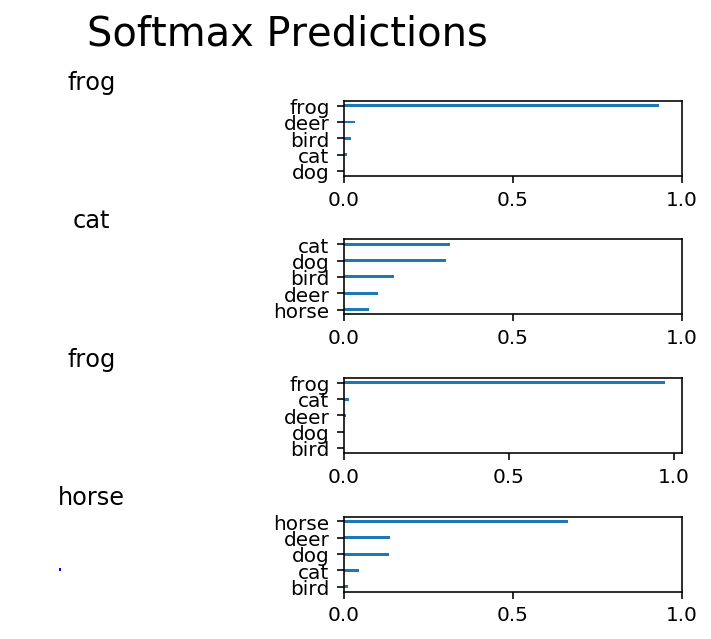

In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = 'D:\Study\Deep_Learning\image_classification'
n_samples = 4
top_n_predictions = 5

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_testing.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()